## Stock data

Baseado no estudo de [Curtis Miller](https://ntguardian.wordpress.com) sobre a análise de dados do mercado de valores.

* [Black–Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)
* [The mathematical equation that caused the banks to crash](https://www.theguardian.com/science/2012/feb/12/black-scholes-equation-credit-crunch)

## Obtendo e visualizando dados de estoque

O primeiro ponto é obter os dados de estoque. Para isso vamos utilizar os dados disponíveis em dois sites referências e com dados abertos: **Yahoo Finance** e **Google Finance**. Vamos criar um **DataFrame** com os dados obtidos.

In [5]:
#http://blog.yhat.com/posts/stock-data-python.html
import pandas as pd
import pandas_datareader as web
import datetime

# Define o range de data a ser pesquisada
start = datetime.datetime(2016,1,1)
#end = datetime.date.today()
end = datetime.datetime(2016,12,31)

# Vamos obter os dados do estoque da Apple; O ticker da Apple é AAPL
# No método de extração de dados, o primeiro argumento é a série que queremos buscar, 
#o segundo argumento é a fonte, neste caso "yahoo" para o Yahoo! Finance, 
#o terceiro e quarto parametros são a data de início e data final da pesquisa
apple = web.DataReader("AAPL", "yahoo", start, end)

type(apple)

apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.790649,67649400
2016-01-05,105.750000,105.849998,102.410004,102.709999,99.239845,55791000
2016-01-06,100.559998,102.370003,99.870003,100.699997,97.297760,68457400
2016-01-07,98.680000,100.129997,96.430000,96.449997,93.191338,81094400
2016-01-08,98.550003,99.110001,96.760002,96.959999,93.684120,70798000


Analisando o resultado, vemos que **Open** é o preço da ação no início do dia de negociação (vale notar que este valor não precisa ser o preço de fechamento do pregão anterior). **High** é o preço mais alto que o **estoque** alcançou no dia de negociação. **Low** é o menor preço que as ações alcançaram no dia de negociação. **Close** é o valor do preço do **estoque** na hora do encerramento das negociações. Pulando uma coluna temos o **Volume** que indica quantos `estoques` foram negociados no dia. A coluna **Adj Close** ou **Fechamento ajustado** é o preço do fechamento do `estoque` que ajusta o preço do mesmo para as ações coorporativas. Este é o preço de fechamento em qualquer dia de negociação que foi alterado para incluir quaisquer distribuições e ações corporativas que ocorreram em qualquer momento antes da abertura do dia seguinte. O preço de fechamento ajustado é freqüentemente usado ao examinar retornos históricos ou realizar uma análise detalhada sobre estes retornos históricos.

* http://www.investopedia.com/terms/a/adjusted_closing_price.asp
* https://vantagepointtrading.com/trading-glossary/trading-glossary-a/adjusted-closing-price-definition-and-uses/


## Visualizando dados de estoque

Agora que temos os dados de estoque vamos trabalhar na visualização. 

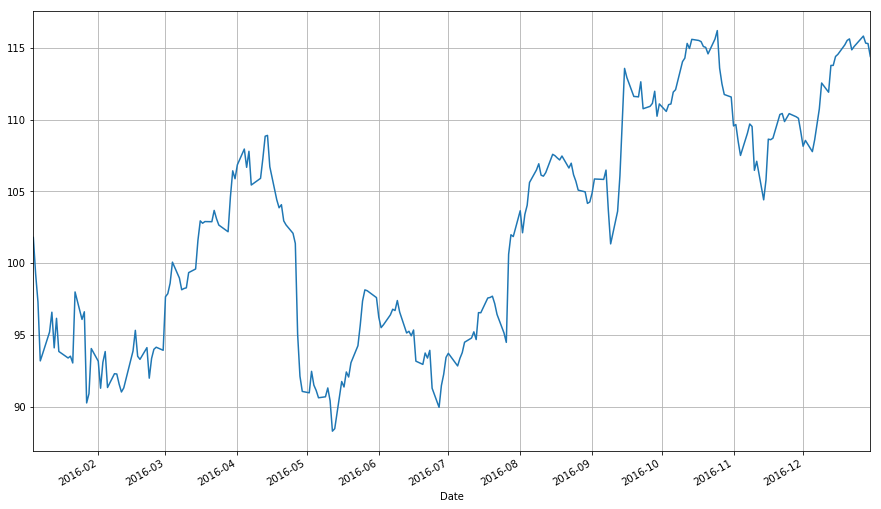

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Definindo o tamanho do plot

# Exibir o "adjusted closing price" para as ações de estoque da AAPL
apple["Adj Close"].plot(grid = True)

O resultado do código acima será um `linechart` baseado no campo **Adj Close**. Para uma visualização significativa, temos que considerar pelo menos quatro variáveis, **Open**, **High**, **Low** e **Close**.

Uma saída seria traçar 4 linhas para comparar os resultados, outra seria utilizar uma visualização de **candelabro** ou **candlestick**.

A variação dos preços quando analisadas por meio de candlesticks pode indicar importantes momentos de compra e venda:

* a ação vem caindo, é um bom momento para compra?
* a ação vem subindo, é um bom momento para venda ou ainda há potencial para alta?

Vamos voltar ao Japão do século século XVIII, quando o arroz era a grande riqueza de todos os fazendeiros abastados. Muitas negociações eram feitas com esse produto: compra, venda, armazenagem e até mesmo contratos futuros! Esse sofisticado comércio tinha milhares de negociadores por todo o país, e até “bolsas de valores” onde o arroz era negociado. A sofisticação deste mercado não parava por aí. Desde de esta época já haviam investidores aplicando conhecimentos de análise técnica sobre as variações do preço do arroz, por meio de um tipo de gráfico bastante particular, eram os atualmente chamados Candlesticks.

No século XIX, o investidor americano [Steve Nison](http://candlecharts.com/candlestick-charting-training.html), percebeu que esta aplicação podia obter resultados excelentes quando aplicados sobre outros ativos como ações, contratos futuros e até mesmo moedas. Nison escreveu e publicou então um dos clássicos da análise técnica, o livro chamado “Japanese Candlestick Charting Techniques“, que ensina de modo único como entender os chamados padrões de candlesticks.

Os 3 elementos dos Candlesticks

1. Período

O principal conceito dos candlesticks é que cada candle representa o que ocorreu com o preço de uma ação durante um determinado período de tempo. Cada candle pode representar 1 minuto, 5 minutos, 1 hora, 1 semana, 1 mês e até mesmo 1 ano. Você é que escolhe.

2. Formato

O formato do candle por sua vez é determinado por importantes valores que o preço da ação atingiu durante este determinado período. São os preço de:

* abertura
* fechamento
* mínimo
* máximo
Estes valores dão forma aos dois elementos que compões um Candle:

* o corpo (que traz as informações de fechamento e abertura), e
* a sombra (que informa os máximos e mínimos do período)

3. Cor

O terceiro elemento que compões um candlestick é a sua cor, e isso determina se o candlestick é de alta ou de baixa.

Quando o preço de fechamento está abaixo do preço de abertura, significa que o preço da ação caiu durante aquele determinado período, e o Candle será de baixa.

Quando o preço de fechamento for maior que o preço de abertura, significa que o preço subiu durante aquele período e o candlestick será de alta.


### Candlestick with matplotlib
Esse gráfico pode ser criado com matplotlib , embora isso requer um esforço considerável. Abaixo temos uma implementação sugerida por `Miller` que está documentada [aqui](http://matplotlib.org/examples/pylab_examples/finance_demo.html).

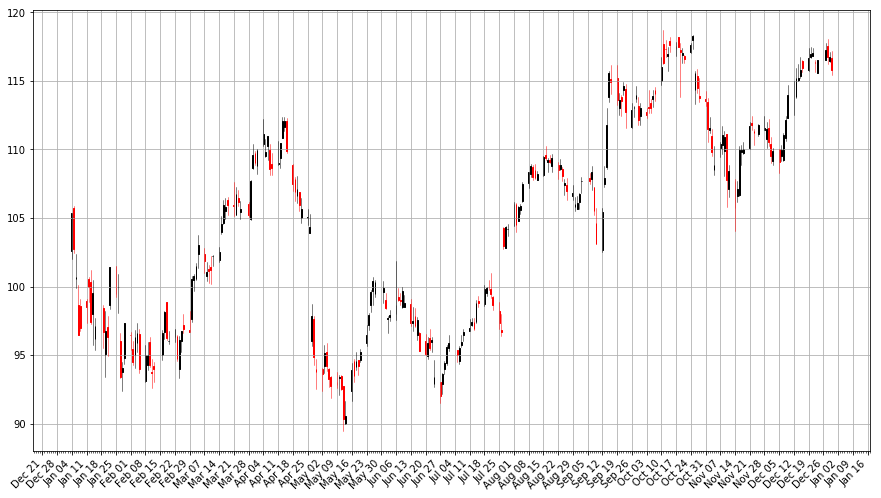

In [7]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

pandas_candlestick_ohlc(apple)

In [8]:
microsoft = web.DataReader("MSFT", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)

# Abaixo, crio um DataFrame consistindo no preço de fechamento ajustado dos estoques, 
#fazendo uma lista desses objetos e usando um método de associação
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})

stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,101.790649,741.840027,52.433533
2016-01-05,99.239845,742.580017,52.672737
2016-01-06,97.297760,743.619995,51.715916
2016-01-07,93.191338,726.390015,49.917099
2016-01-08,93.684120,714.469971,50.070198


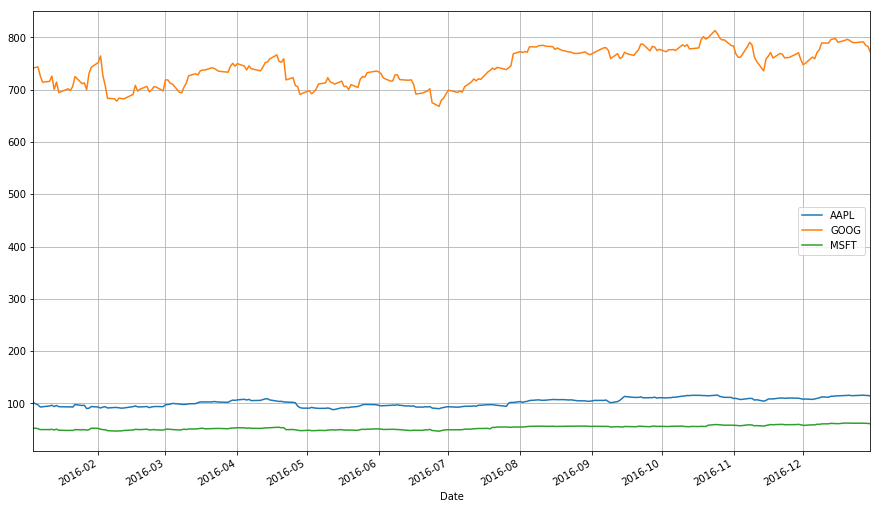

In [9]:
stocks.plot(grid = True)

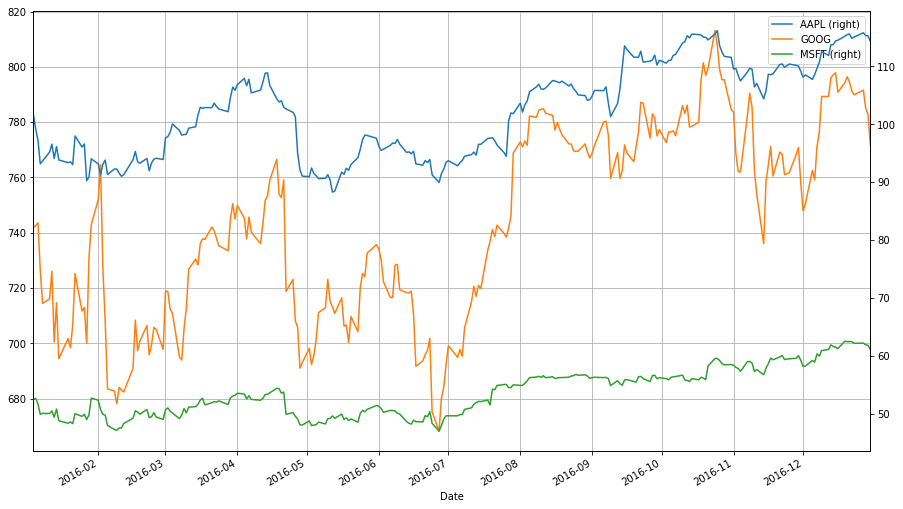

In [10]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)